# Online Retail Customer Segmentation and Forming Growth Strategy
### by Ashley Chen






### Dataset Overview
> This is a online retail’s dataset, and it has some basic transaction data like InvoiceID, CustomerID, datetime, price and so on.
> *   Period: 2010/01/12 ~ 2011/12/09
* Data Source: [UCI Online Retail Data Set](https://archive.ics.uci.edu/ml/datasets/online+retail#)

### Problem Statement
> For a online retail who want to increase customer LTV by segmenting the customers into several groups with similar characteristics and form growth strategies for each group.



# Data Wrangling


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt

import seaborn as sns
from matplotlib import pyplot as plt

# 1 Data Assessing


In [4]:
# load data
df = pd.read_excel('dataset/Online Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
def df_info(df): 

    """ print DataFrame info """

    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    nuniques = df.apply(lambda x: x.nunique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    
    cols = ['types', 'counts', 'distincts', 'nulls', 'missing ratio', 'nuniques', 'skewness']
    info = pd.concat([types, counts, distincts, nulls, missing_ration, nuniques, skewness], axis = 1, sort=True)
    info.columns = cols
    
    print("There are ", df.shape[1], " columns and ", df.shape[0], " rows in dataset.")
    print("There are ", df[df.duplicated()].shape[0], " duplicated rows in dataset.")
    print('___________________________\nData types:\n',info.types.value_counts())
    print('___________________________')
    return info

details = df_info(df)
display(details.sort_values(by='missing ratio', ascending=False))

<ipython-input-5-bf1674886297>:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness = df.skew()


There are  8  columns and  541909  rows in dataset.
There are  5268  duplicated rows in dataset.
___________________________
Data types:
 object            4
float64           2
datetime64[ns]    1
int64             1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ratio,nuniques,skewness
CustomerID,float64,406829,4373,135080,24.926694,4372,0.029835
Description,object,540455,4224,1454,0.268311,4223,NaN
Country,object,541909,38,0,0.000000,38,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,23260,NaN
InvoiceNo,object,541909,25900,0,0.000000,25900,NaN
Quantity,int64,541909,722,0,0.000000,722,-0.264076
StockCode,object,541909,4070,0,0.000000,4070,NaN
UnitPrice,float64,541909,1630,0,0.000000,1630,186.506972


# 2 Data Cleaning


## 2.1 Preprocessing

* Remove refund data
* Remove negative value in Quantity and UnitPrice
* Remove the NA value in CustomerID, since we need to confirm every member's transaction records for following RFM analysis.
* Remove duplicate data

In [6]:
retail = df.copy()

In [7]:
#Remove duplicate data
retail.drop_duplicates(inplace = True)

# Calculate refund ratio
retail['InvoiceNo'] = retail['InvoiceNo'].astype("string")
refund_ratio = (retail['InvoiceNo'].str.contains('c', case=False) == True).mean()
print("refund ratio: {}".format(refund_ratio))

# Remove refund transaction
retail = retail[retail['InvoiceNo'].str.contains('c', case=False) == False]

# remove negative Quantity, Price value
retail = retail[retail['Quantity'] > 0]
retail = retail[retail['UnitPrice'] > 0]

# remove CustomerID containing NA value
print("NA customerID: {}".format(retail['CustomerID'].isna().mean()))
retail = retail.dropna(subset=['CustomerID'])

refund ratio: 0.017238712658928408
NA customerID: 0.2518413802826562


In [8]:
pd.DataFrame([{'products': len(retail['StockCode'].value_counts()),    
               'transactions': len(retail['InvoiceNo'].value_counts()),
               'customers': len(retail['CustomerID'].unique().tolist()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3665,18532,4338


## 2.2 Transformation


* Create TotalSum
* Record the day when every customer first purchased as Cohort Day

In [9]:
# Calculate total consumption amount of each invoice
retail['TotalSum'] = retail['Quantity'] * retail['UnitPrice']

In [10]:
# Define a function that will parse the date
def get_day(x): 
  return dt.datetime(x.year, x.month, x.day) 

# Create InvoiceDay column
retail['InvoiceDay'] = retail['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = retail.groupby('CustomerID')['InvoiceDay'] 
print(grouping)

# Assign a minimum InvoiceDay value to the dataset: first day
retail['CohortDay'] = grouping.transform('min')

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,InvoiceDay,CohortDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


* Transform invoice data into customer record and store in **`datamart`**
* Note: Many invoice records of a day seen as an order (= 1 Frequency)

In [11]:
# Suppose we analyze on 2011/12/10
snapshot_date = dt.datetime(2011, 12, 10)

In [12]:
datamart = retail.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'TotalSum': 'sum',
    'Country': 'first',
    'CohortDay': 'first'})

# orders in a day seen as one order
tmp = retail.groupby(['CustomerID', 'InvoiceDate']).agg({'InvoiceNo': 'count'})
datamart['Frequency'] = tmp.groupby(['CustomerID']).size()

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

datamart

,Recency,MonetaryValue,Country,CohortDay,Frequency
CustomerID,,,,,
12346.0,325,77183.60,United Kingdom,2011-01-18,1
12347.0,2,4310.00,Iceland,2010-12-07,7
12348.0,75,1797.24,Finland,2010-12-16,4
12349.0,18,1757.55,Italy,2011-11-21,1
12350.0,310,334.40,Norway,2011-02-02,1
...,...,...,...,...,...
18280.0,277,180.60,United Kingdom,2011-03-07,1
18281.0,180,80.82,United Kingdom,2011-06-12,1
18282.0,7,178.05,United Kingdom,2011-08-05,2


# 3 Process



> 1. EDA
> 2. RFM Model
> 3. K-Means



## 3.1 EDA


In [13]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [14]:
df_country_order = datamart.groupby(['Country']).agg({'Frequency': 'sum'})
uk_percent = datamart.Country.apply(lambda x: True if x == 'United Kingdom' else False).mean()

# plot
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{"type": "bar"}, {"type": "pie"}]],
    subplot_titles=("Amount of Orders in Countries", "Internal Market Orders")
    )

fig.add_trace(
    go.Bar(
        x=df_country_order.index, 
        y=df_country_order['Frequency']
        ),
        1, 1
    )

fig.add_trace(
        go.Pie(
            labels=['UK', 'other countries'], 
            values=[uk_percent, 1-uk_percent]
        ),
        1, 2
    )

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'))
fig.show()

In [15]:
df_plot = retail.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'}).reset_index()

# Top 50 Customers Sales Amount
top_customer = df_plot.sort_values(by=['TotalSum'], ascending=False)
top_customer['CustomerID'] = top_customer['CustomerID'].astype("string")
sales_percent_50 = top_customer['TotalSum'][:50].sum()/ retail['TotalSum'].sum() * 100

fig = px.bar(
    top_customer[:50], 
    x='CustomerID', 
    y='TotalSum',
    title="Top 30 Customers {:.2f}% Sales Amount".format(sales_percent_50)
    )

fig.show()

# Top 10 Customers Sales Amount
sales_percent_10 = top_customer['TotalSum'][:10].sum()/ retail['TotalSum'].sum() * 100

# Top 10 Order Sales Amount
top_customer_order = df_plot.sort_values(by=['InvoiceNo'], ascending=False)
top_customer_order['CustomerID'] = top_customer_order['CustomerID'].astype("string")
oder_percent_10 = sum(top_customer_order['InvoiceNo'][:10])/sum(top_customer_order['InvoiceNo']) * 100


# plot
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=( 
                    "Top 10 Customers {:.2f}% Sales Amount".format(sales_percent_10),
                    "Top 10 Customers {:.2f}% Order Amount".format(oder_percent_10),
                    )
    )

fig.add_trace(
        go.Bar(
        x=top_customer[:10].CustomerID, 
        y=top_customer[:10].TotalSum
        ),
        1, 1
    )

fig.add_trace(
        go.Bar(
        x=top_customer_order[:10].CustomerID, 
        y=top_customer_order[:10].InvoiceNo
        ),
        1, 2
    )

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

**Note:** We only use customer data in United Kingdom for follwing analysis.


In [16]:
# only use UK data
datamart = datamart[datamart['Country'] == 'United Kingdom']

## 3.2 RFM metrics
- Recency: The amount of time since the customer’s most recent transaction (use days).


- Frequency: Total number of transactions made by the customer.

- MonetaryValue: Total amount that the customer has spent across all transactions (during a defined period).


In [17]:
# Create labels for Recency, Frequency, MonetaryValue
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=5, labels=r_labels).astype(int)
f_groups = pd.qcut(datamart['Frequency'].rank(method="first"), q=5, labels=f_labels, duplicates='drop').astype(int)
m_groups = pd.qcut(datamart['MonetaryValue'], q=5, labels=m_labels).astype(int)

# Create new columns R, F, M
datamart = datamart.assign(R=r_groups.values, F=f_groups.values, M=m_groups.values)

## 3.3 Segments using K-Means


### Pre-process
- Standardize the RFM metrics


In [18]:
# Unskew the data
datamart_log = np.log(datamart[['Recency', 'Frequency', 'MonetaryValue']])
datamart_log.replace([np.inf, -np.inf, np.NaN], 0, inplace=True) # avoid np.inf resulting from log(0)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_log.index, columns=datamart_log.columns)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



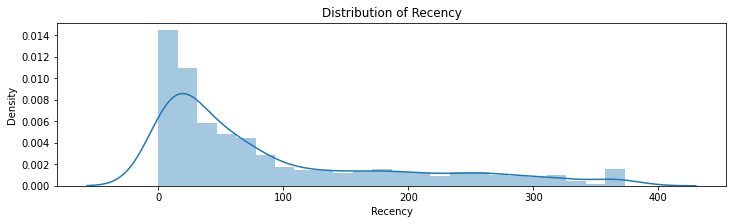

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



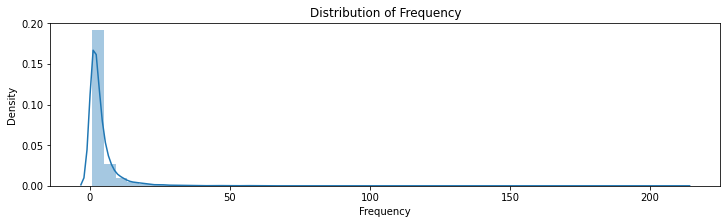

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



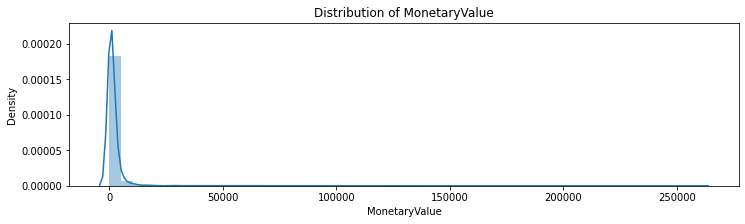

In [19]:
# Plot recency, frequency, monetary value distribution
colnames = ['Recency', 'Frequency', 'MonetaryValue']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(datamart[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



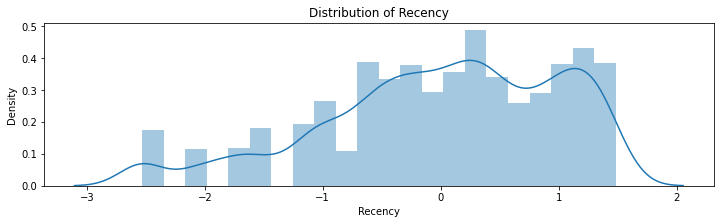

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



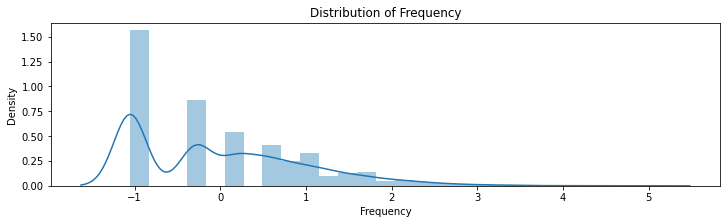

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



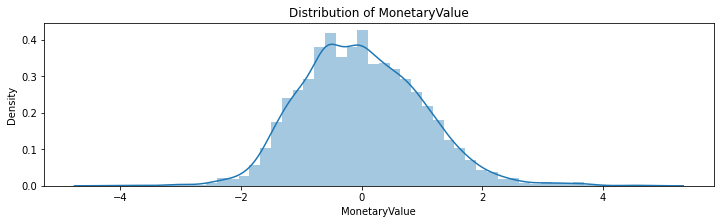

In [20]:
colnames = ['Recency', 'Frequency', 'MonetaryValue']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(datamart_normalized[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

### Choosing the right k
#### 1 Elbow Method
- Elbow Method doesn't clearly show an elbow here. From the figure below, maybe using 3 to 6 would be good ideas, but to make sure choosing the best k, I decided to use Silhouette index to find the right k.

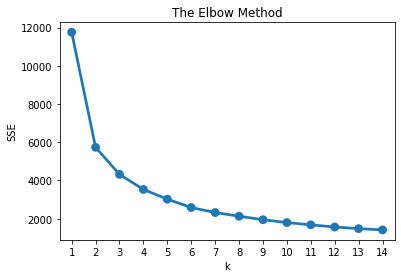

In [21]:
# using Elbow Method 

sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

#### 2 Silhouette index
- After assessing Silhouette score, I found that k = 4 has the highest average Silhouette score, 0.42(see vertical green lines).


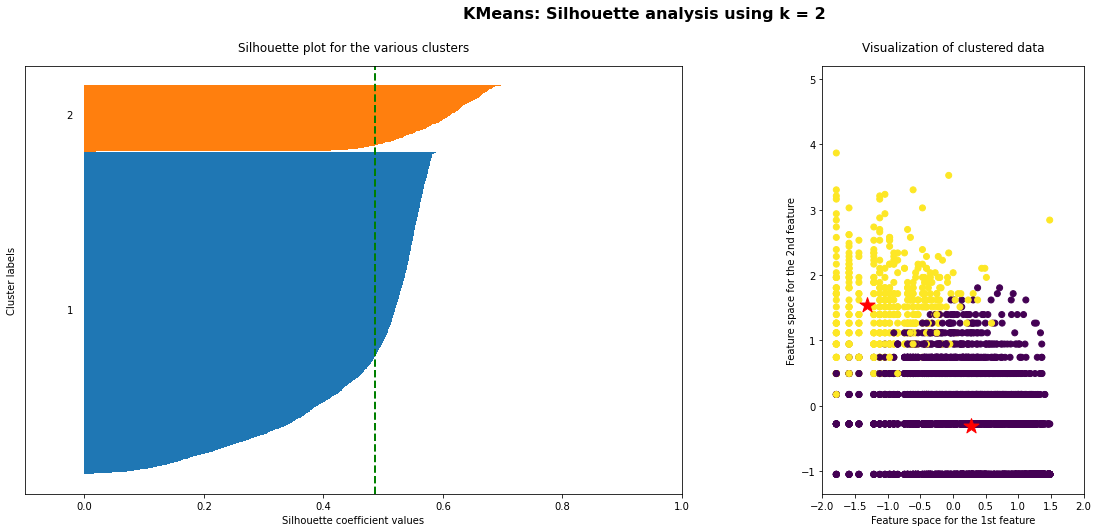

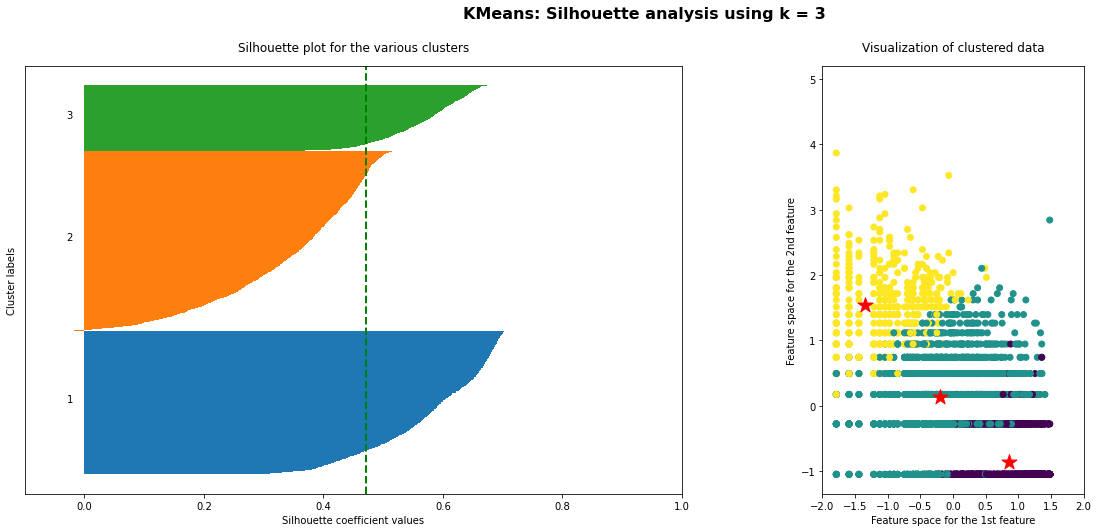

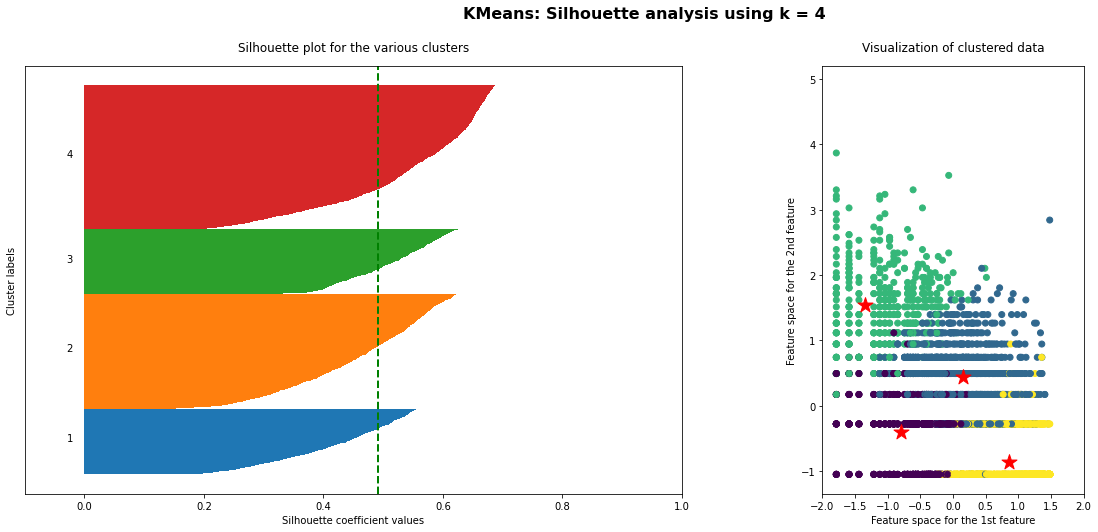

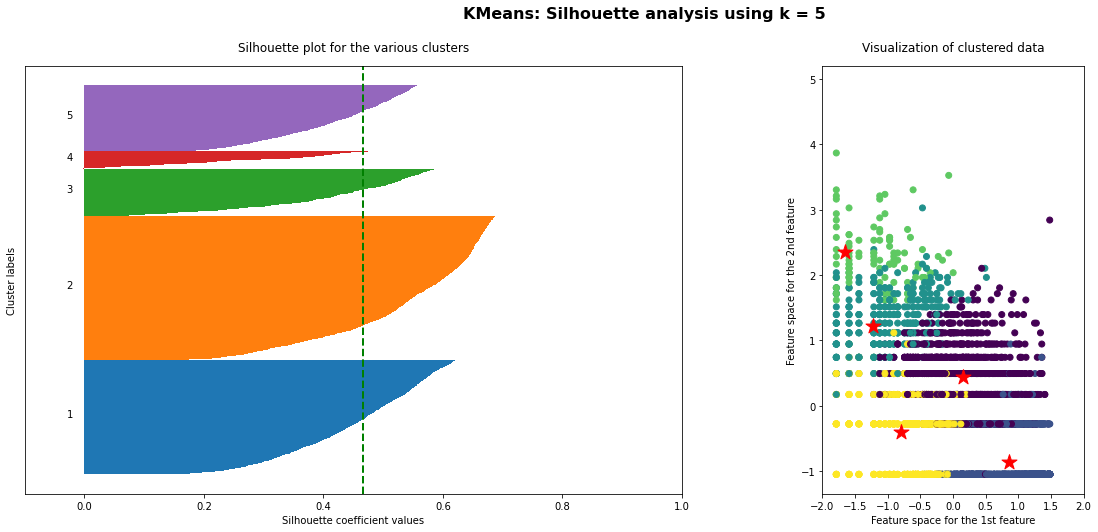

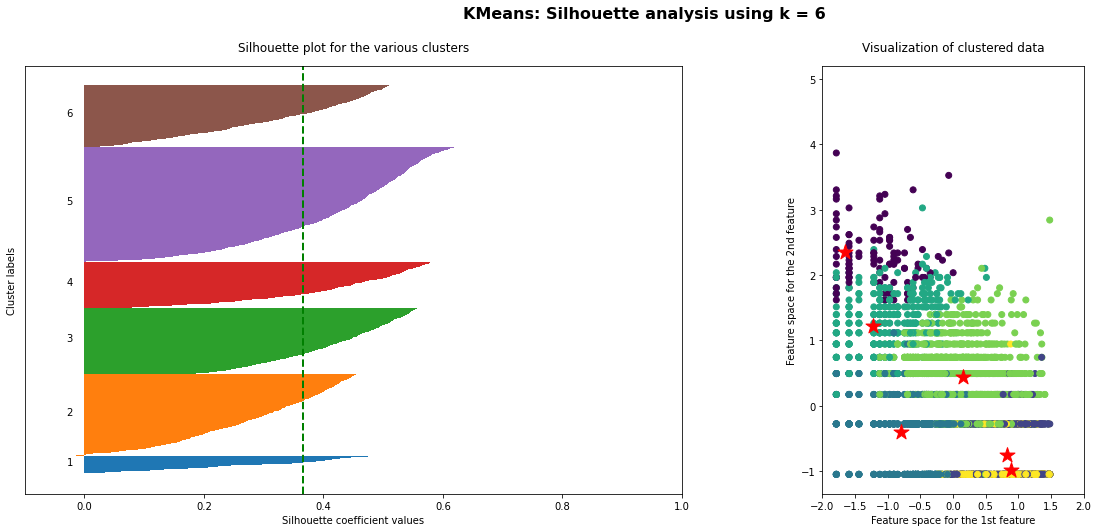

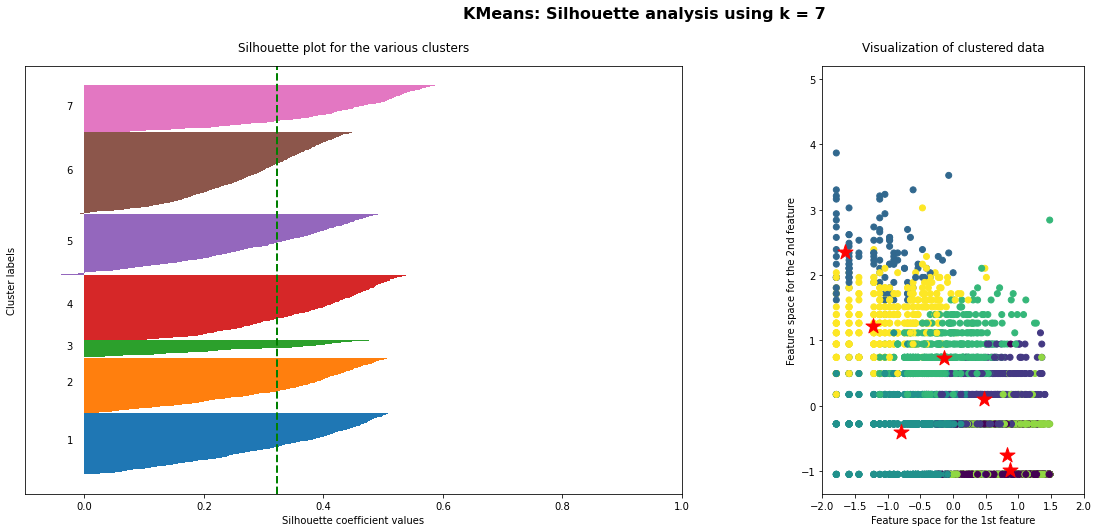

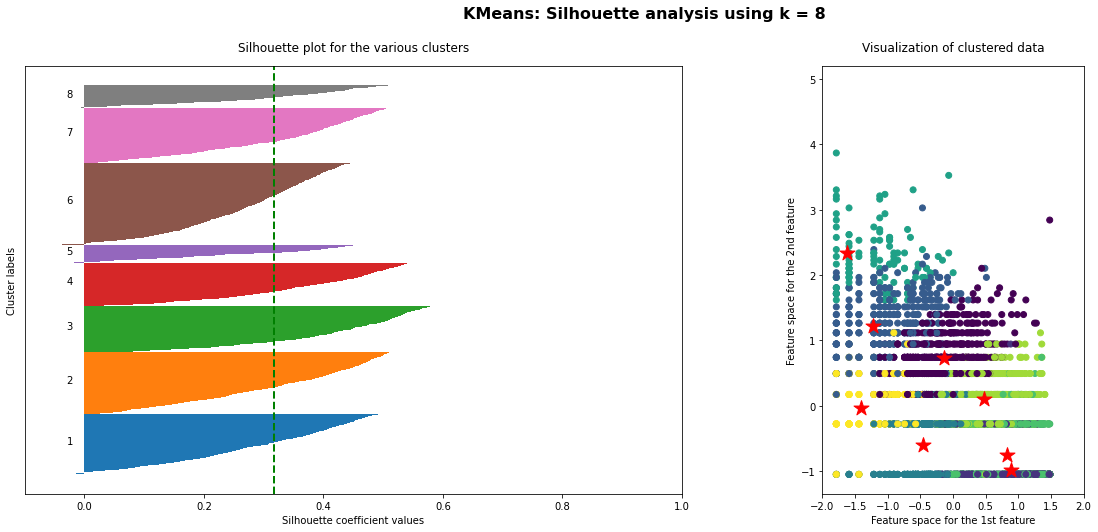

In [34]:
# Silhouette index method
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4, 5, 6, 7, 8]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(datamart_normalized)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(datamart_normalized, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(datamart_normalized.iloc[:, 0], datamart_normalized.iloc[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'KMeans: Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);


#### 3 Comparing with other clustering methods: Hierachical clustering and GMMs
- I will be using Silhouette index to validate the results.

**Result**
- KMeans performs best when k=4 and scores 0.49
- Hierachical clustering performs best when k=4 and scores 0.49
- GMMs performs best when k=4 and scores 0.49

> **Conclusion of model choosing: KMeans with k=4**

          KM        HC      GMMs   k
0   0.486251  0.488157  0.488157   2
1   0.470842  0.470842  0.470842   3
2   0.490980  0.490980  0.490980   4
3   0.466889  0.477554  0.466208   5
4   0.366329  0.374855  0.449750   6
5   0.322452  0.305781  0.374818   7
6   0.316639  0.290860  0.300532   8
7   0.328716  0.280450  0.303895   9
8   0.323620  0.290928  0.303353  10
9   0.321314  0.289418  0.318419  11
10  0.338149  0.298469  0.303228  12
11  0.336066  0.310361  0.296024  13
12  0.340118  0.319460  0.287292  14
13  0.315821  0.303650  0.275086  15


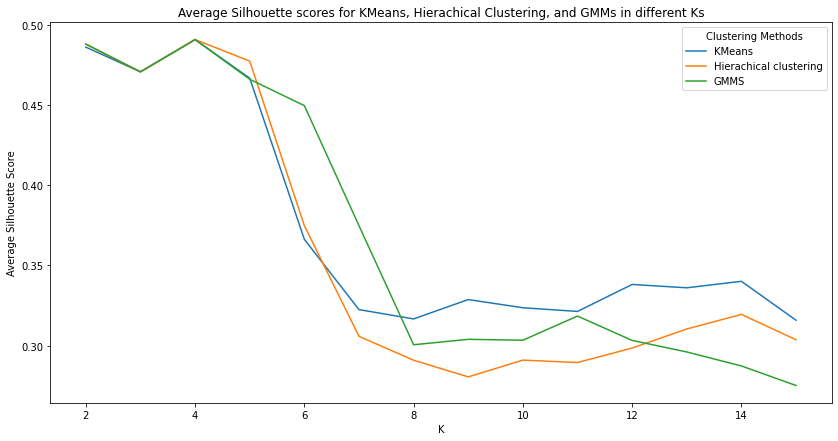

In [35]:
def plot_km_hc_gmms_in_different_ks(df_std, start_k, end_k):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.mixture import GaussianMixture
    
    avg_silhouette_scores = []

    for k in range(start_k, end_k+1):

        # Run the KMeans algorithm
        km = KMeans(n_clusters=k)
        km_labels = km.fit_predict(df_std)

        # Run the Hierachical clustering algorithm
        hc = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(df_std)
        hc_labels = hc.labels_

        # Run the GMMs algorithm
        gm = GaussianMixture(covariance_type="spherical", n_components=k, random_state=0).fit(df_std)
        gm_labels = GaussianMixture(n_components=k, random_state=0).fit_predict(df_std)

        # calculate average silhouette scores
        km_silhouette_vals = silhouette_samples(df_std, km_labels)
        hc_silhouette_vals = silhouette_samples(df_std, hc_labels)
        gm_silhouette_vals = silhouette_samples(df_std, gm_labels)
        km_avg_score = np.mean(km_silhouette_vals)
        hc_avg_score = np.mean(hc_silhouette_vals)
        gm_avg_score = np.mean(gm_silhouette_vals)
        avg_silhouette_scores.append([km_avg_score, hc_avg_score, gm_avg_score])

    df_avg_silhouette_scores = pd.DataFrame(avg_silhouette_scores, columns = ['KM', 'HC', "GMMs"])
    df_avg_silhouette_scores["k"] = range(start_k, end_k+1)
    print(df_avg_silhouette_scores)
    
    # plot male and female left-handedness rates vs. age
    fig, ax = plt.subplots() # create figure and axis objects
    fig.set_size_inches(14, 7)
    ax.set_title('Average Silhouette scores for KMeans, Hierachical Clustering, and GMMs in different Ks')
    ax.plot('k', 'KM', data=df_avg_silhouette_scores) 
    ax.plot('k', 'HC', data=df_avg_silhouette_scores) 
    ax.plot('k', 'GMMs', data=df_avg_silhouette_scores) 
    ax.legend(['KMeans',"Hierachical clustering", "GMMS"], title="Clustering Methods") # add a legend
    ax.set_xlabel('K')
    ax.set_ylabel("Average Silhouette Score");
    
plot_km_hc_gmms_in_different_ks(datamart_normalized, 2, 15)

# 4 Analyzing clustering results


In [24]:
# Using kmeans with k=4
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_
datamart_normalized = datamart_normalized.assign(Cluster=cluster_labels)
datamart['Cluster'] = datamart_normalized['Cluster']

# Group the data by cluster
grouped = datamart.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
datamart_cluster = grouped.agg({
    'Recency': 'mean',
    'R': 'mean',
    'Frequency': 'mean',
    'F': 'mean',
    'MonetaryValue': 'mean',
    'M': 'mean'
  }).round(1)

datamart_cluster['percent'] = (grouped.agg({'Recency': 'count'}) / len(datamart)).round(2)

datamart_cluster.rename({'Recency': 'AVG Recency',
                         'Frequency': 'AVG Frequency',
                         'MonetaryValue': 'AVG MonetaryValue',
                         'R': 'AVG R Score',
                         'F': 'AVG F Score',
                         'M': 'AVG M Score'}, axis=1, inplace=True)

datamart_cluster

,AVG Recency,AVG R Score,AVG Frequency,AVG F Score,AVG MonetaryValue,AVG M Score,percent
Cluster,,,,,,,
0,17.8,4.3,2.0,2.5,473.1,2.3,0.17
1,70.3,2.9,4.2,3.8,1653.8,3.9,0.29
2,179.8,1.7,1.3,1.7,324.9,1.8,0.37
3,9.6,4.7,13.0,4.8,6991.7,4.8,0.17


## Snake Plot

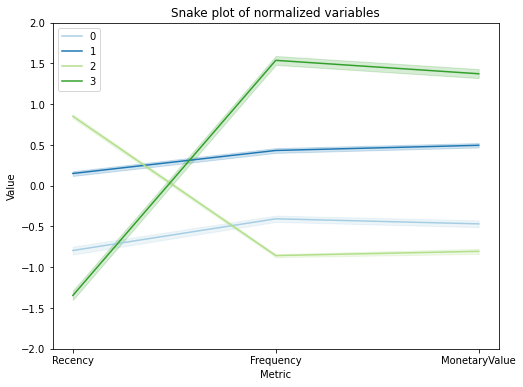

In [25]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(
  					datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value'
					)

# Set plot size
plt.figure(figsize=(8, 6))

# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
ax = sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster', palette="Paired")
plt.legend(loc='best')
ax.set_ylim([-2, 2])

plt.show()

## Scatter Plot

In [26]:
datamart_scatter = datamart.copy()

#Remove the outlier for visualization
y1 = datamart_scatter['Frequency']
size = datamart_scatter.shape[0]
removed_outliers = y1.between(y1.quantile(.05), y1.quantile(.95))
print(str(y1[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = datamart_scatter[~removed_outliers].index 
datamart_scatter.drop(index_names, inplace=True)

#Remove the outlier for visualization
y2 = datamart_scatter['Recency']
size = datamart_scatter.shape[0]
removed_outliers = y2.between(y2.quantile(.05), y2.quantile(.95))
print(str(y2[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = datamart_scatter[~removed_outliers].index 
datamart_scatter.drop(index_names, inplace=True)

#Remove the outlier for visualization
y3 = datamart_scatter['MonetaryValue']
size = datamart_scatter.shape[0]
removed_outliers = y3.between(y3.quantile(.05), y3.quantile(.95))
print(str(y3[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = datamart_scatter[~removed_outliers].index 
datamart_scatter.drop(index_names, inplace=True)

3731/3920 data points remain.
3401/3731 data points remain.
3061/3401 data points remain.


Recency Vs frequency

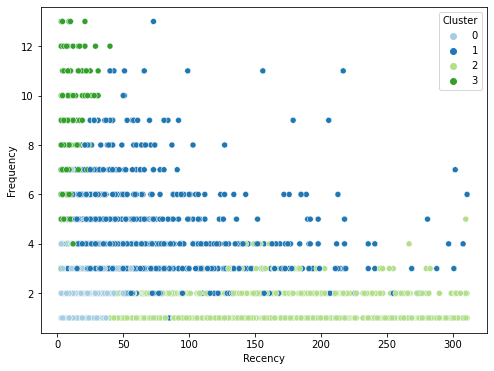

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=datamart_scatter, x="Recency", y="Frequency", hue="Cluster", palette="Paired")
plt.show()

Frequency Vs Monetary

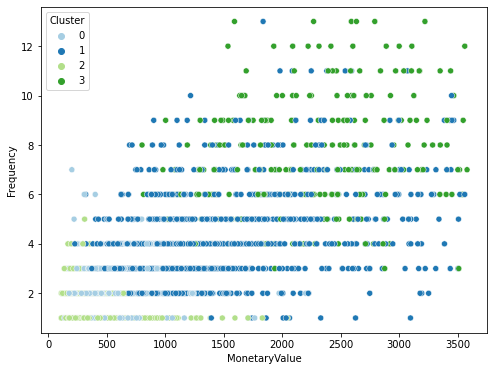

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=datamart_scatter, x="MonetaryValue", y="Frequency", hue="Cluster", palette="Paired")
plt.show()

In [29]:
# 3d Scatter plot
datamart_scatter['Cluster'] = datamart_scatter['Cluster'].astype(str)

import plotly.express as px
fig = px.scatter_3d(datamart_scatter,x='Recency', y='Frequency', z='MonetaryValue',
              color='Cluster', opacity=0.7,color_discrete_sequence=px.colors.qualitative.G10)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_traces(marker_size = 3)

fig.show()

In [30]:
# output plotly
fig.write_html("index.html", include_plotlyjs="cdn")

## Name each cluster and create radar charts
* Group 0: New Customer
* Group 1: Mid Customer
* Group 2: Low Value Customer
* Group 3: Loyal Customer


In [31]:
datamart_cluster = datamart_cluster.reset_index()
datamart_cluster["Cluster"] = datamart_cluster["Cluster"].map({0: 'New Customer', 
                                                               1: 'Mid Customer',
                                                               2: 'Low Value Customer',
                                                               3: 'Loyal Customer'})

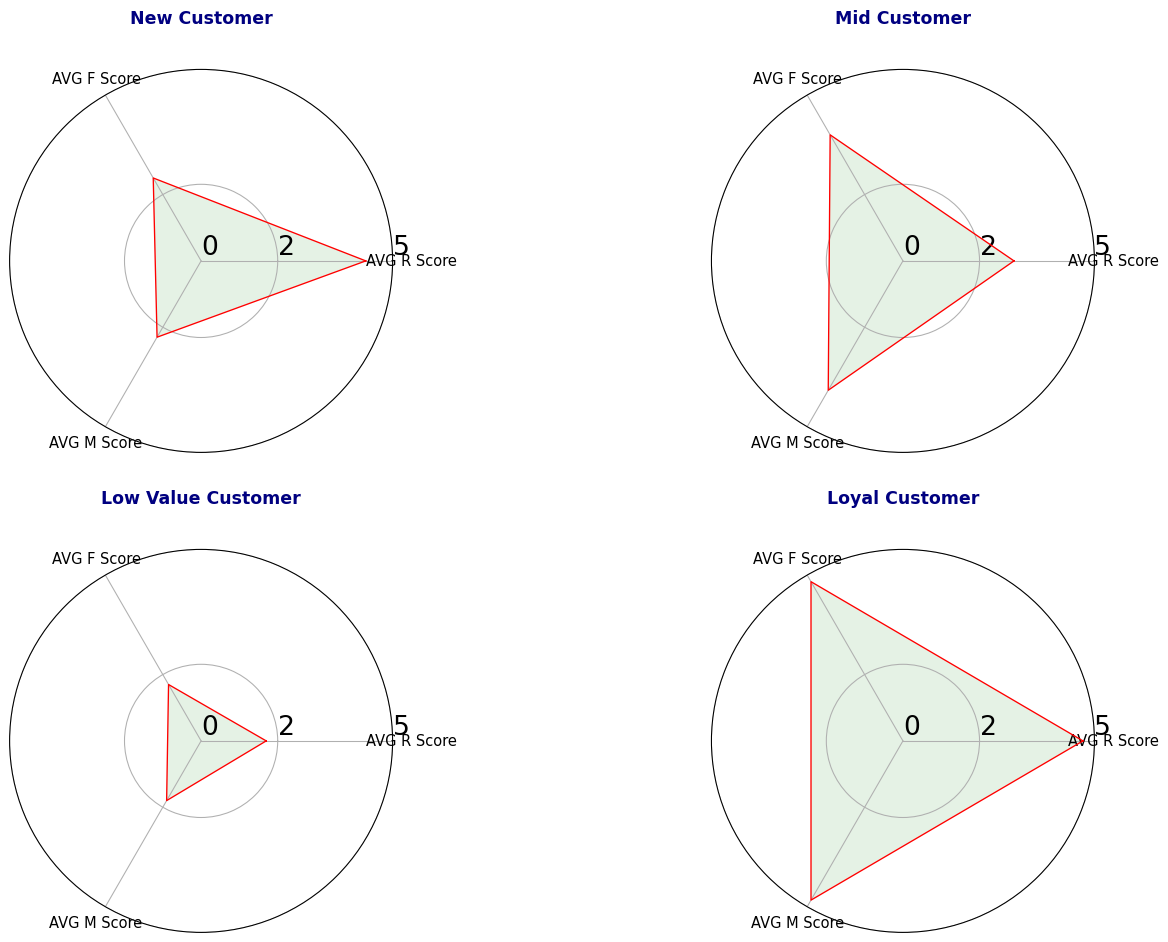

In [32]:
# create radar charts
def multiple_radars(df, columns, row):
    # Libraries
    from math import pi
    N = len(columns)
    columns_no_need = df[df.columns.difference(columns)]

    # But we need to repeat the first value to close the circular graph:
    values=df.loc[row].drop(columns_no_need).values.flatten().tolist()
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot

    ax = plt.subplot(2, 2, row+1, polar=True) 

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], ['AVG R Score', 'AVG F Score', 'AVG M Score'], size=11)
    plt.title(name[row], size=13, y=1.1,fontweight="bold",  color='navy')
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,2,5], 
               ["0","2","5"], size=20)
    plt.ylim(0,5)

    # Plot data
    ax.plot(angles, values, linewidth=1, color='r', linestyle='solid')
    # Fill area
    ax.fill(angles, values, 'g', alpha=0.1)


my_dpi=96
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)

# datamart_cluster = datamart_cluster.reset_index()
# number of variable
name = ['New Customer', 'Mid Customer', 'Low Value Customer', 'Loyal Customer']
columns=['AVG R Score', 'AVG F Score', 'AVG M Score']
for i in range(0,4): 
    multiple_radars(datamart_cluster, columns, i)
plt.tight_layout(pad=3.0)